In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load Dataframe as df

In [96]:
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv',encoding='latin1')

### Rename Columns

In [97]:
df.rename(columns = {'emotion_in_tweet_is_directed_at': 'Product', 'is_there_an_emotion_directed_at_a_brand_or_product': 'Emotion', 'tweet_text': 'Text'}, inplace= True)

In [98]:
df['Product'].isnull().sum()

5802

In [99]:
df['Product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: Product, dtype: int64

### New column to seperate apple and google products

In [100]:
dict1 = {'iPad': 'apple', 'Apple' : 'apple', 'iPad or iPhone App' : 'apple', 'iPhone' : 'apple', 'Other Apple product or service': 'apple',
        'Google' : 'google', 'Other Google product or service': 'google', 'Android App': 'google', 'Android': 'google'}
df['company'] = df['Product'].map(dict1)

In [101]:
df['Text'] = df['Text'].str.lower()

In [102]:
app = df.loc[((df.Text.str.contains('apple')) | df.Text.str.contains('ipad') | df.Text.str.contains('iphone')) & df.Product.isnull()]

In [103]:
gog = df.loc[((df.Text.str.contains('google')) | df.Text.str.contains('android')) & df.Product.isnull()]

In [104]:
def company_search(text):
    if type(text) == float:
        return 'unknown'
    elif 'apple' in text:
        return 'apple'
    elif 'ipad' in text:
        return 'apple'
    elif 'iphone' in text:
        return 'apple'
    elif 'google' in text:
        return 'google'
    elif 'android' in text:
        return 'google'
    else:
        return 'unknown'
    

In [105]:
df['company'] = df['Text'].apply(company_search)

In [106]:
df['company'].value_counts()

apple      5525
google     2781
unknown     787
Name: company, dtype: int64

In [107]:
df['Emotion'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: Emotion, dtype: int64

### Simplifying emotion category into +, - or neutral

In [108]:
neutral_dict = {'No emotion toward brand or product' : 'Neutral emotion', "I can't tell": 'Neutral emotion', 'Positive emotion': 'Positive emotion',
               'Negative emotion': 'Negative emotion'}

In [109]:
df['Emotion'] = df['Emotion'].map(neutral_dict)

In [110]:
df['Emotion'].value_counts()

Neutral emotion     5545
Positive emotion    2978
Negative emotion     570
Name: Emotion, dtype: int64

In [111]:
group = df.groupby(['company', 'Emotion']).count()['Text']

In [173]:
group

company  Emotion         
apple    Negative emotion     420
         Neutral emotion     2974
         Positive emotion    2131
google   Negative emotion     149
         Neutral emotion     1823
         Positive emotion     809
unknown  Negative emotion       1
         Neutral emotion      747
         Positive emotion      38
Name: Text, dtype: int64

<Figure size 864x576 with 0 Axes>

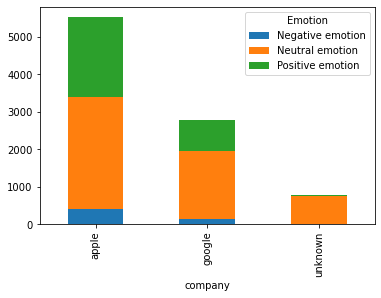

In [113]:
plt.figure(figsize=(12,8))
fig = group.unstack().plot(kind='bar', stacked=True)


## Basic Vectorizer 

In [117]:
pos_or_neg = df.loc[(df['Emotion'] == 'Positive emotion') | (df['Emotion'] == 'Negative emotion') ]

In [133]:
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [120]:
target_dict = {'Positive emotion' : 1, 'Negative emotion' : 0}

In [121]:
pos_or_neg['target'] = pos_or_neg['Emotion'].map(target_dict)

<ipython-input-121-0b9c8df80b80>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_or_neg['target'] = pos_or_neg['Emotion'].map(target_dict)


In [123]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pos_or_neg['Text'], pos_or_neg['target'], random_state=42)

In [125]:
sw = stopwords.words('english')

In [130]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [134]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the satire corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    print(doc)
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [146]:
token_X_train = [doc_preparer(doc, sw) for doc in X_train]
token_X_test = [doc_preparer(doc, sw) for doc in X_test]

['giving', 'away', 'ipad', 'x', 'boxes', 'books', 'mention', 'sxsw', 'techenvy']
['setting', 'ipad', 'swift', 'upbeat', 'service', 'morning', 'sxsw', 'apple', 'pop', 'store']
['third', 'time', 'charm', 'gt', 'gt', 'gt', 'google', 'launch', 'new', 'social', 'network', 'sxsw', 'cnet', 'news', 'link']
['mention', 'used', 'think', 'started', 'making', 'great', 'apps', 'official', 'sxsw', 'app', 'ipad', 'blows', 'versions', 'site', 'away']
['hopefully', 'best', 'thing', 'comes', 'sxsw', 'fact', 'people', 'flew', 'austin', 'pick', 'ipad']
['among', 'things', 'missing', 'sxsw', 'google', 'aclu', 'dance', 'party']
['biggest', 'frustration', 'sxsw', 'far', 'one', 'looks', 'going', 'glued', 'iphone']
['expect', 'lots', 'buzz', 'ipad', 'sxsw', 'since', 'comes', 'tomorrow', 'support', 'flash', 'maybe', 'link', 'elonsxsw']
['queue', 'apple', 'pop', 'store', 'sxsw', 'still', 'long']
['way', 'call', 'ipad', 'count', 'sxsw', 'reasonable', 'think', 'one', 'every', 'people']
['apple', 'employee', 'psych

['mention', 'hey', 'taariq', 'howdy', 'texas', 'fav', 'sxsw', 'app', 'far', 'official', 'one', 'link', 'lt', 'android', 'get', 'iphone', 'usguys']
['trying', 'update', 'software', 'iphone', 'download', 'sxsw', 'app', 'far', 'luck', 'wonder', 'phone', 'mexico']
['def', 'could', 'use', 'ipad', 'sxsw', 'today', 'tweeting', 'via', 'iphone', 'sorta', 'pretty', 'much', 'sux']
['ipad', 'everywhere', 'sxsw', 'link']
['rt', 'mention', 'google', 'hotpot', 'yelp', 'killer', 'impressive', 'integration', 'personalized', 'recommendations', 'really', 'fast', 'mention', 'sxsw']
['want', 'likability', 'virgin', 'trustworthiness', 'zappos', 'product', 'apple', 'mention', 'pnid', 'sxsw', 'enchantment']
['cool', 'apple', 'opening', 'temporary', 'store', 'ipad', 'launch', 'sxsw', 'link']
['freaking', 'everyone', 'ipad', 'iphone', 'mac', 'wow', 'sxsw']
['google', 'launch', 'new', 'social', 'network', 'circles', 'linking', 'u', 'closely', 'peeps', 'u', 'connect', 'w', 'possibly', 'today', 'mention', 'sxsw']


['rt', 'mention', 'google', 'marissa', 'mayer', 'extolling', 'coolness', 'google', 'mobile', 'maps', 'v', 'quot', 'mobile', 'surpassed', 'desktop', 'usage', 'st', 'time', 'year', 'quot', 'sxsw', 'sxswi']
['rt', 'mention', 'lose', 'hour', 'tonight', 'sxsw', 'attendees', 'blame', 'microsoft', 'apple', 'get', 'credit', 'fixing', 'christmas']
['rt', 'mention', 'got', 'shiny', 'new', 'ipad', 'sxsw', 'discover', 'new', 'music', 'link', 'built', 'html', 'flash', 'looks', 'great', 'ipad']
['sxsw', 'wanted', 'get', 'right', 'dokobots', 'really', 'ingenious', 'iphone', 'game']
['iphone', 'droid', 'apps', 'less', 'downloads', 'total', 'sxsw']
['rt', 'mention', 'apple', 'pop', 'store', 'selling', 'ipad', 'sxsw', 'link', 'via', 'mention', 'tech', 'retail']
['rt', 'mention', 'giving', 'away', 'ipad', 'sxsw', 'mappers', 'entry', 'amazingly', 'easy', 'details', 'link']
['sxsw', 'crowd', 'swarms', 'ipad', 'launch', 'link', 'via', 'mention', 'sxsw', 'apple']
['mention', 'might', 'need', 'go', 'apple', '

['loving', 'hello', 'holler', 'gram', 'ipad', 'link', 'via', 'mention', 'sxsw']
['rt', 'mention', 'good', 'news', 'austin', 'eats', 'bbq', 'iphone', 'available', 'link', 'itunes', 'austin', 'bbq', 'sxsw', 'sxswi', 'via', 'mention']
['rt', 'mention', 'marissa', 'mayer', 'google', 'connect', 'digital', 'amp', 'physical', 'worlds', 'mobile', 'link', 'sxsw']
['smart', 'company', 'apple', 'set', 'open', 'pop', 'shop', 'core', 'sxsw', 'action', 'link', 'apple']
['mention', 'good', 'question', 'amp', 'brands', 'answer', 'probably', 'except', 'apple', 'course', 'maybe', 'netflix', 'sxsw']
['love', 'waves', 'link', 'ipad', 'webber', 'japan', 'sxsw']
['score', 'rt', 'mention', 'google', 'handing', 'free', 'pi', 'pi', 'day', 'sxsw', 'win']
['google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'google', 'circles', 'sxsw', 'link']
['rt', 'mention', 'sxsw', 'apple', 'store', 'tonight', 'handing', 'stickers', 'amp', 'coupons', 'mention', 'dodo', 'cases', 'ipad']
['sxsw', 'go'

['fuck', 'love', 'austin', 'left', 'youtube', 'google', 'party', 'maggie', 'maes', 'fun', 'times', 'got', 'youtube', 'tube', 'socks', 'lol', 'sxsw', 'austin']
['yet', 'walk', 'conference', 'room', 'look', 'like', 'apple', 'ad', 'think', 'nothing', 'else', 'sxsw']
['google', 'maps', 'mobile', 'demonstration', 'rocked', 'world', 'sxsw', 'uosxsw', 'marissamayer']
['pubcamp', 'kirkus', 'sxsw', 'download', 'qrank', 'ipad', 'iphone', 'come', 'pubcamp', 'sxsw', 'prizes']
['mention', 'mention', 'reading', 'book', 'flight', 'sxsw', 'guy', 'next', 'reading', 'ipad', 'boom']
['really', 'long', 'line', 'get', 'aclu', 'google', 'party', 'sure', 'wait', 'sxsw']
['hope', 'everyone', 'awesome', 'weekend', 'sxsw', 'know', 'mention', 'giving', 'away', 'great', 'apple', 'prizes']
['great', 'time', 'google', 'party', 'sxswi', 'sxsw']
['unveiling', 'pop', 'apple', 'store', 'scarborough', 'building', 'sxsw', 'link']
['rt', 'mention', 'dawn', 'ipad', 'app', 'week', 'early', 'help', 'prep', 'sxsw', 'link']
['

['mention', 'gave', 'great', 'minute', 'preso', 'designing', 'android', 'mccannsxsw', 'sxsw']
['wait', 'line', 'sxsw', 'apple', 'store', 'ipad']
['rt', 'mention', 'rt', 'mention', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link', 'sxsw', 'via', 'mention', 'pcbuzz']
['great', 'session', 'mention', 'ipad', 'design', 'good', 'ui', 'insights', 'tapworthy', 'hisxsw', 'sxsw']
['believe', 'good', 'rt', 'mention', 'life', 'would', 'much', 'better', 'ipad', 'brainwashed', 'lines', 'sxsw']
['nothing', 'quite', 'like', 'sxsw', 'make', 'want', 'ipad', 'desperately', 'almost', 'drooling', 'guy', 'next']
['google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'mention', 'sxsw', 'sxswi', 'link', 'via', 'mention']
['rt', 'mention', 'diller', 'google', 'tv', 'quot', 'first', 'product', 'good', 'consumer', 'product', 'basically', 'quot', 'sxsw', 'diller']
['rt', 'mention', 'everywhere', 'crazy', 'look', 

['rt', 'mention', 'ipad', 'upgrade', 'newest', 'ios', 'yet', 'tweetdeck', 'unstable', 'nten', 'ntc', 'sxsw', 'sxswi']
['lt', 'guess', 'ipad', 'unsix', 'tweetup', 'thanks', 'mention', 'amp', 'mention', 'sxsw', 'happydance']
['grouped', 'nice', 'app', 'groups', 'aber', 'leider', 'nur', 'f', 'r', 'iphone', 'link', 'sxsw']
['sxsw', 'app', 'google', 'maps', 'pretty', 'sure', 'schwag', 'bag', 'waste', 'paper']
['interested', 'hear', 'different', 'google', 'buzz', 'rt', 'mention', 'get', 'ready', 'word', 'quot', 'circles', 'quot', 'trending', 'sxswi', 'sxsw']
['mention', 'apple', 'great', 'example', 'retail', 'store', 'layed', 'future', 'registers', 'checkout', 'line', 'sxsw']
['mention', 'good', 'job', 'mention', 'sxsw', 'went', 'home', 'amp', 'watched', 'season', 'guild', 'sucks', 'tweet', 'abt', 'iphone', 'hijack', 'top', 'tweet', 'lol']
['perfect', 'attention', 'detail', 'rt', 'mention', 'google', 'recreated', 'code', 'pac', 'man', 'doodle', 'original', 'bugs', 'included', 'sxsw', 'google

['grabbed', 'seat', 'ballroom', 'hear', 'mention', 'google', 'sxsw']
['mention', 'think', 'google', 'presentation', 'nice', 'see', 'retail', 'peeps', 'sxsw']
['win', 'ipad', 'sxsw', 'via', 'mention', 'sxsw', 'link']
['mention', 'sure', 'use', 'free', 'app', 'checking', 'bands', 'sxsw', 'link']
['josh', 'clark', 'sxsw', 'session', 'ipad', 'tablet', 'development', 'first', 'note', 'ipad', 'leisure', 'planning', 'restful', 'device', 'tapworthy', 'webvisions']
['looks', 'interesting', 'good', 'luck', 'sxsw', 'localmind', 'available', 'iphone', 'link']
['rt', 'mention', 'less', 'hours', 'announce', 'details', 'ipad', 'giveaway', 'sxsw', 'sxswi']
['cool', 'iphone', 'app', 'launched', 'sxsw', 'flypost', 'community', 'bulletin', 'board', 'w', 'location', 'learn', 'link', 'link']
['mention', 'great', 'news', 'u', 'mention', 'twit', 'crew', 'apple', 'building', 'temporary', 'store', 'sxsw', 'u', 'get', 'ur', 'ipad']
['winning', 'free', 'sxsw', 'music', 'sampler', 'itunes', 'tracks', 'quot', 'ind

['fully', 'anticipate', 'every', 'geek', 'douche', 'toting', 'ipad', 'sxsw', 'people', 'also', 'worth', 'going']
['rt', 'mention', 'apple', 'knows', 'game', 'sxsw', 'bring', 'ipad', 'people', 'link']
['rt', 'mention', 'new', 'mike', 'tyson', 'game', 'coming', 'iphone', 'link', 'iphone', 'sxsw', 'videogames', 'tyson', 'art', 'cartoon']
['phone', 'way', 'battery', 'wise', 'believe', 'week', 'week', 'comfortable', 'typing', 'ipad', 'sixth', 'st', 'sxsw']
['good', 'job', 'rt', 'mention', 'yes', 'gowalla', 'wins', 'best', 'andoid', 'app', 'team', 'android', 'choice', 'awards', 'thanks', 'sxsw']
['rt', 'mention', 'heading', 'free', 'google', 'sponsored', 'happy', 'hour', 'semantic', 'web', 'austin', 'mention', 'fogo', 'de', 'ch', 'sxsw']
['quot', 'tattoo', 'ipad', 'quot', 'chalked', 'pavement', 'mean', 'sxsw', 'applefanatic']
['mention', 'sxsw', 'forget', 'mention', 'plan', 'schedule', 'plus', 'free', 'iphone', 'app', 'link']
['rt', 'mention', 'pull', 'iphone', 'look', 'busy', 'fit', 'sxsw',

['temperature', 'going', 'rt', 'mention', 'mention', 'mention', 'amp', 'mention', 'fun', 'google', 'pic', 'sxsw', 'link']
['rt', 'mention', 'cunning', 'apple', 'keeping', 'ipad', 'popup', 'store', 'open', 'late', 'next', 'sxsw', 'parties', 'impulsive', 'lat', 'cont', 'link']
['rumor', 'apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'sxsw', 'ipad', 'launch', 'link']
['mention', 'feeling', 'many', 'shiny', 'new', 'ipad', 'sxsw']
['foodspotting', 'iphone', 'app', 'success', 'sxsw', 'finding', 'food', 'crave', 'link']
['rt', 'mention', 'gt', 'rt', 'mention', 'google', 'people', 'work', 'people', 'rather', 'people', 'work', 'agileagency', 'sxsw']
['still', 'use', 'tweetie', 'mac', 'amp', 'running', 'leopard', 'pariah', 'sxsw', 'wish', 'least', 'android', 'something', 'make', 'cool']
['information', 'mention', 'morning', 'apple', 'store', 'getting', 'build', 'sxsw', 'two', 'weeks', 'ipad', 'love', 'jealous']
['rt', 'mention', 'get', 'sxsw', 'iphone', 'app', 'thanks', 'mention

['mention', 'prob', 'going', 'hit', 'temp', 'apple', 'store', 'setting', 'near', 'sxsw', 'nice', 'apple', 'link']
['cool', 'potential', 'non', 'text', 'applications', 'iphone', 'awesome', 'sxsw']
['google', 'interested', 'location', 'based', 'tech', 'indoor', 'venues', 'businesses', 'convention', 'centers', 'etc', 'tech', 'needs', 'improve', 'first', 'sxsw']
['best', 'sessions', 'seen', 'far', 'sxsw', 'morning', 'music', 'ixd', 'designing', 'ipad', 'interfaces', 'winning']
['well', 'done', 'see', 'tonight', 'rt', 'mention', 'w', 'mention', 'wrote', 'hollergram', 'ipad', 'app', 'sxsw', 'link']
['overload', 'info', 'delivered', 'google', 'kill', 'discovery', 'google', 'says', 'ppl', 'lose', 'curiosity', 'wonder', 'need', 'serendipity', 'sxsw']
['love', 'new', 'ipad', 'seems', 'much', 'faster', 'fluid', 'original', 'seems', 'natural', 'hold', 'excited', 'use', 'sxsw', 'week']
['rt', 'mention', 'ridiculous', 'see', 'someone', 'taking', 'photo', 'session', 'ipad', 'cannot', 'wait', 'see', '

['rt', 'mention', 'marc', 'ecko', 'sxsw', 'launches', 'iphone', 'app', 'autodial', 'political', 'change', 'link', 'edreform', 'edtech', 'eduvc', 'fightthepaddle']
['mention', 'heard', 'apple', 'going', 'open', 'special', 'store', 'expecting', 'lot', 'customers', 'sxsw']
['many', 'ipad', 'think', 'apple', 'could', 'sell', 'sxsw', 'attendees', 'set', 'pop', 'store', 'convention', 'center', 'sxsw']
['rt', 'mention', 'line', 'apple', 'store', 'insane', 'sxsw']
['pinoy', 'insights', 'sxsw', 'conf', 'conf', 'mobile', 'ipad', 'app', 'great', 'use', 'even', 'plan', 'day', 'friends', 'sxsw']
['foursquare', 'twitter', 'launched', 'slick', 'new', 'iphone', 'apps', 'week', 'conveniently', 'time', 'tech', 'fest', 'sxsw', 'link', 'rf']
['iphone', 'battery', 'keep', 'tweets', 'thanks', 'apple', 'sxsw', 'precommerce']
['quot', 'google', 'launch', 'major', 'new', 'social', 'network', 'quot', 'really', 'dont', 'need', 'another', 'social', 'network', 'link', 'sxsw']
['rt', 'mention', 'apple', 'opened', '

['strong', 'rumours', 'abt', 'google', 'unveiling', 'new', 'social', 'network', 'called', 'circles', 'sxsw', 'look', 'interesting', 'link']
['someone', 'asks', 'leo', 'ipad', 'sxsw', 'says', 'email', 'send', 'one', 'free']
['sxsw', 'google', 'authenticator', 'app', 'mobile', 'devices', 'step', 'ahead']
['gt', 'gt', 'mention', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link', 'sxsw']
['got', 'shiny', 'new', 'ipad', 'sxsw', 'discover', 'new', 'music', 'link', 'built', 'html', 'flash', 'looks', 'great', 'ipad']
['sxsw', 'iphone', 'app', 'one', 'worst', 'use', 'long', 'time']
['new', 'iphone', 'new', 'ipad', 'come', 'running', 'fast', 'cuz', 'every', 'girl', 'crazy', 'sharp', 'mac', 'man', 'strums', 'guitar', 'sxsw']
['mention', 'fully', 'expect', 'quot', 'ipad', 'shamed', 'quot', 'sxsw']
['protip', 'avoid', 'austin', 'area', 'apple', 'stores', 'friday', 'sxsw']
['added', 'sxsw', 'flights', 'planely', 'matching', 'people', 'planes', 

['ipad', 'seen', 'wild', 'people', 'say', 'fast', 'still', 'pics', 'terrible', 'sxsw']
['geniuses', 'rt', 'mention', 'may', 'actually', 'buy', 'ipad', 'tomorrow', 'apple', 'temporary', 'store', 'downtown', 'austin', 'sxsw']
['finally', 'got', 'new', 'iphone', 'tweet', 'phone', 'time', 'sxsw', 'gah', 'torture', 'addictedtotheinterwebs']
['dont', 'bite', 'ears', 'rt', 'mention', 'austin', 'convention', 'center', 'today', 'w', 'mention', 'fam', 'showing', 'new', 'iphone', 'game', 'sxsw']
['dissapointment', 'rt', 'mention', 'new', 'ubersocial', 'iphone', 'app', 'store', 'includes', 'uberguide', 'sxsw', 'sponsored', 'cont']
['sxsw', 'google', 'saving', 'drivers', 'time', 'fuel', 'link', 'seo', 'sem', 'googlemaps', 'mobile', 'topnews']
['rt', 'mention', 'line', 'wrapping', 'around', 'block', 'ipad', 'second', 'day', 'sxsw', 'link']
['android', 'rt', 'mention', 'new', 'mobile', 'apps', 'using', 'sxsw', 'link']
['must', 'app', 'ipad', 'going', 'sxsw', 'http', 'itunes', 'apple', 'com', 'us', 'a

['impressed', 'far', 'ipad', 'slim', 'form', 'quot', 'instant', 'quot', 'ness', 'seen', 'tried', 'one', 'yet', 'sxsw', 'sxswi']
['sxsw', 'ze', 'frank', 'missed', 'childhood', 'walk', 'project', 'google', 'street', 'view', 'enables', 'stunning', 'revelations', 'link']
['trying', 'steve', 'wozniak', 'drink', 'free', 'thanks', 'google', 'h', 'ckers', 'sxsw', 'mention', 'speakeasy', 'link']
['google', 'maps', 'useful', 'get', 'better', 'sxsw']
['outside', 'panels', 'people', 'skip', 'barely', 'get', 'anything', 'work', 'iphone', 'sxsw', 'needs', 'shrink', 'k', 'people']
['bit', 'jealous', 'seeing', 'sxsw', 'attendees', 'ipad', 'ipad', 'seems', 'obsolete']
['cool', 'rt', 'mention', 'rumor', 'apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'sxsw', 'ipad', 'link']
['thank', 'heavens', 'nice', 'travelers', 'got', 'iphone', 'charger', 'another', 'delayed', 'mention', 'passenger', 'sxsw']
['idea', 'combine', 'google', 'analytics', 'tools', 'know', 'website', 'program', 'something'

['apple', 'installs', 'pop', 'shop', 'sxsw', 'apple', 'setting', 'special', 'pop', 'shop', 'visitors', 'link']
['spent', 'come', 'sxsw', 'already', 'used', 'ipad', 'wait', 'couple', 'city', 'blocks', 'ipad', 'sxsw', 'link']
['mention', 'apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'sxsw', 'ipad', 'launch', 'link', 'gswsxsw']
['rt', 'mention', 'google', 'art', 'project', 'would', 'great', 'virtual', 'field', 'trip', 'kids', 'museums', 'around', 'world', 'edtech', 'sxsw']
['rt', 'mention', 'sxsw', 'novelty', 'ipad', 'news', 'apps', 'fades', 'fast', 'among', 'digital', 'delegates', 'link', 'sxsw']
['got', 'craving', 'sxsw', 'minds', 'created', 'app', 'foodspotting', 'link', 'iphone', 'apps']
['rt', 'mention', 'best', 'thing', 'heard', 'weekend', 'sxsw', 'quot', 'gave', 'ipad', 'money', 'japan', 'relief', 'need', 'ipad', 'quot', 'lt', 'amen', 'gt']
['google', 'new', 'quot', 'route', 'around', 'quot', 'feature', 'gives', 'alternate', 'routes', 'avoid', 'traffic', 'collecti

['google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'link', 'sxsw', 'via', 'mention']
['rt', 'mention', 'ipad', 'also', 'cartoonishly', 'large', 'digital', 'camera', 'sxsw', 'cstejas', 'link']
['rt', 'mention', 'wondering', 'many', 'mention', 'come', 'back', 'sxsw', 'ipad', 'maybe', 'everyone']
['rt', 'mention', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link', 'sxsw', 'gt', 'gt', 'good']
['mayer', 'admits', 'google', 'needs', 'step', 'one', 'one', 'customer', 'service', 'would', 'set', 'amazing', 'precedent', 'sxsw', 'fh']
['yay', 'love', 'ipad', 'perfectly', 'portable', 'travel', 'thanks', 'sxsw', 'pop', 'store']
['congrats', 'bernd', 'florian', 'mention', 'launch', 'guguchu', 'ticket', 'terminal', 'iphone', 'app', 'ahead', 'sxsw', 'link']
['dan', 'neumann', 'announced', 'launch', 'organic', 'first', 'consumer', 'facing', 'ipad', 'app', 'broadfeed', 'sxsw', 'check']
['building', 'success', 'google', '

['rt', 'mention', 'updated', 'iphone', 'app', 'song', 'info', 'select', 'streams', 'incl', 'mention', 'amp', 'live', 'video', 'streaming', 'time', 'sxsw', 'link']
['hmm', 'ipad', 'interface', 'talk', 'ux', 'research', 'hmm', 'like', 'sound', 'politics', 'behind', 'html', 'sxsw']
['maybe', 'little', 'excited', 'seeing', 'bear', 'creatures', 'iphone', 'vs', 'evo', 'video', 'er', 'priorities', 'sxsw']
['mention', 'thanks', 'sxsw', 'android', 'app', 'checking', 'link']
['way', 'sxsw', 'see', 'tonight', 'hopefully', 'new', 'ipad', 'mention', 'san', 'francisco', 'international', 'airport', 'sfo', 'link']
['rt', 'mention', 'wow', 'shakespeare', 'pub', 'th', 'st', 'delete', 'button', 'iphone', 'video', 'camera', 'sxsw']
['mention', 'really', 'disappointed', 'ipad', 'app', 'lots', 'error', 'messages', 'switch', 'tweet', 'deck', 'rest', 'sxsw']
['rt', 'rt', 'mention', 'ipad', 'takes', 'sxsw', 'video', 'link', 'rt', 'mention', 'ip', 'link', 'vegas', 'news']
['dear', 'sxsw', 'goer', 'please', 'loo

['panel', 'flipboard', 'one', 'fave', 'ipad', 'apps', 'sxsw']
['line', 'apple', 'pop', 'store', 'sxsw', 'squeal', 'link']
['brilliant', 'use', 'case', 'sxsw', 'quot', 'mention', 'kik', 'concierge', 'service', 'great', 'get', 'mention', 'android', 'iphone', 'add', 'sxsw', 'user', 'amp', 'ask', 'away', 'quot']
['rt', 'mention', 'check', 'new', 'android', 'app', 'bizzy', 'using', 'check', 'sxsw', 'link']
['apple', 'white', 'earbuds', 'good', 'symbol', 'need', 'social', 'proof', 'ipod', 'launched', 'knew', 'new', 'toy', 'guykawasaki', 'sxsw']
['rt', 'mention', 'robot', 'wars', 'steampunk', 'time', 'machines', 'mystery', 'boxes', 'electronics', 'awesome', 'austin', 'tacos', 'super', 'happy', 'dev', 'house', 'google', 'win', 'sxsw']
['wish', 'sxsw', 'meeting', 'everyone', 'teamandroid', 'rest', 'android', 'community', 'next', 'year']
['google', 'scale', 'tiny', 'changes', 'even', 'colors', 'blue', 'meaningful', 'optimum', 'shade', 'blue', 'links', 'sxsw', 'mention']
['farmers', 'like', 'blac

['aron', 'pilhofer', 'new', 'york', 'times', 'design', 'guru', 'khoi', 'vinh', 'express', 'scepticism', 'ipad', 'news', 'apps', 'sxsw', 'link']
['mention', 'new', 'ipad', 'apps', 'speech', 'therapy', 'communication', 'showcased', 'mention', 'sxsw', 'conference', 'link', 'sxswi', 'assistivetech']
['mention', 'yes', 'favorited', 'want', 'win', 'need', 'win', 'doo', 'dah', 'doo', 'dah', 'pushio', 'sxsw', 'ipad']
['joined', 'heaving', 'river', 'flow', 'see', 'marissa', 'mayer', 'google', 'sxsw']
['poursite', 'sxsw', 'learning', 'life', 'changing', 'impact', 'ipad', 'real', 'people', 'actual', 'lives', 'bravo']
['dennis', 'crowley', 'mention', 'love', 'work', 'google', 'could', 'benefit', 'working', 'us', 'social', 'well', 'checkins', 'sxsw']
['rt', 'mention', 'whoa', 'hang', 'saw', 'someone', 'without', 'iphone', 'sxsw']
['mention', 'think', 'might', 'quit', 'resume', 'tonight', 'ipad', 'iphone', 'tethering', 'happened', 'better', 'time', 'sxsw']
['one', 'least', 'helpful', 'sessions', 'sx

['ipad', 'envy', 'greater', 'waaaaaa', 'sxsw']
['rt', 'mention', 'debuting', 'new', 'iphone', 'amp', 'droid', 'app', 'sxsw', 'next', 'year', 'makes', 'phone', 'waterproof', 'amp', 'light', 'cigarettes']
['thinking', 'shoulda', 'gone', 'sxsw', 'year', 'first', 'year', 'ipad', 'could', 'interesting', 'sessions', 'sxsw']
['technology', 'apple', 'opening', 'pop', 'store', 'austin', 'sxsw', 'geekfest', 'apple', 'brian', 'lam', 'thousands', 'link', 'tech']
['win', 'awesome', 'ipad', 'quibids', 'custom', 'mention', 'case', 'catch', 'sxsw', 'wearing', 'openbeta', 'vip', 'badge']
['mention', 'apple', 'pop', 'store', 'sxsw', 'blocks', 'long', 'betterthingstodo']
['free', 'sxsw', 'music', 'sampler', 'itunes', 'includes', 'mention', 'barton', 'hollow', 'opens', 'itunes', 'link']
['rt', 'mention', 'mypov', 'winner', 'popup', 'apple', 'store', 'chevy', 'cruze', 'losers', 'investors', 'propping', 'frothy', 'startups', 'w', 'enterprise', 'strategy', 'sxsw']
['quot', 'apple', 'likes', 'pay', 'apple', '

['great', 'see', 'topics', 'avoiding', 'sexy', 'hot', 'ipad', 'conversation', 'hit', 'heart', 'soul', 'accessibility', 'developing', 'world', 'sxsw']
['rt', 'mention', 'quot', 'explanation', 'apple', 'continued', 'survival', 'existence', 'god', 'quot', 'guykawasaki', 'sxsw']
['marissa', 'mayer', 'presentation', 'sxsw', 'demo', 'google', 'maps', 'version', 'mobile', 'pretty', 'impressive']
['could', 'cool', 'rt', 'mention', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link', 'sxsw']
['bad', 'news', 'costs', 'rt', 'mention', 'louis', 'vuitton', 'iphone', 'app', 'called', 'amble', 'digitalluxury', 'sxsw']
['would', 'like', 'know', 'lbs', 'app', 'downloaded', 'commandeered', 'iphone', 'geolocation', 'setting', 'amp', 'relinquish', 'batterykiller', 'sxsw']
['apple', 'opening', 'temp', 'retail', 'store', 'austin', 'sell', 'ipads', 'sxsw', 'attendees', 'tempted']
['rt', 'mention', 'sxsw', 'apple', 'schools', 'marketing', 'experts', 'link'

['google', 'bing', 'page', 'rank', 'panel', 'ridiculously', 'crowded', 'al', 'franken', 'justin', 'timberlake', 'sxsw', 'link']
['chris', 'poole', 'chan', 'recommends', 'google', 'refrigerator', 'magnet', 'game', 'cute', 'shared', 'experience', 'game', 'sxswmoot', 'sxsw', 'sxswi']
['last', 'year', 'sxswi', 'everbody', 'talking', 'ipad', 'year', 'social', 'media', 'driven', 'revolutions', 'year', 'better', 'sxsw']
['catching', 'mention', 'hotel', 'room', 'day', 'sxsw', 'also', 'tweeting', 'new', 'ipad']
['new', 'blog', 'post', 'ipad', 'giveaway', 'link', 'actors', 'diet', 'sxsw']
['checking', 'ipad', 'design', 'headaches', 'tablets', 'call', 'morning', 'link', 'sxsw', 'tapworthy', 'fb']
['brilliant', 'marketing', 'quot', 'apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'quot', 'next', 'sxsw', 'world', 'buy']
['josh', 'williams', 'mention', 'said', 'farmville', 'success', 'wakeup', 'call', 'games', 'quot', 'build', 'quot', 'iphone', 'things', 'going', 'sxsw']
['ipad', 'bet

['rt', 'mention', 'ipad', 'design', 'headaches', 'josh', 'clark', 'tapworthy', 'sxsw', 'link']
['google', 'web', 'fonts', 'pretty', 'sxsw', 'tradeshow', 'link']
['waiting', 'line', 'ipad', 'said', 'may', 'left', 'crossing', 'fingers', 'sxsw']
['anyone', 'news', 'sxsw', 'ipad', 'must', 'course', 'link']
['impressed', 'mention', 'google', 'articulate', 'relevant', 'amp', 'fun', 'sxsw', 'mention', 'austin', 'convention', 'center', 'link']
['looking', 'forward', 'hearing', 'lynn', 'teo', 'tell', 'nice', 'things', 'probably', 'already', 'know', 'ipad', 'navigation', 'uxdes', 'sxsw']
['spark', 'selected', 'finalist', 'team', 'android', 'choice', 'awards', 'austin', 'please', 'come', 'amp', 'support', 'link', 'sxsw']
['looking', 'fwd', 'ipad', 'dj', 'mention', 'mention', 'dark', 'party', 'tonight', 'great', 'first', 'day', 'sxsw', 'link']
['apple', 'sets', 'temporary', 'austin', 'store', 'serve', 'hordes', 'ipad', 'purchasers', 'sxsw', 'link']
['sxsw', 'go', 'app', 'available', 'blackberry', 

['rt', 'mention', 'wonder', 'google', 'impactdashboard', 'demoed', 'become', 'part', 'google', 'analytics', 'bavcid', 'sxsw']
['heading', 'google', 'aclu', 'eff', 'party', 'yep', 'google', 'throwing', 'back', 'reliving', 'old', 'times', 'fun', 'sxsw']
['woot', 'rt', 'mention', 'mention', 'spilled', 'beans', 'next', 'platform', 'flipboard', 'iphone', 'team', 'started', 'working', 'sxflip', 'sxsw']
['twitter', 'iphone', 'anyway', 'remove', 'burn', 'hashtags', 'eg', 'sxsw', 'v', 'v', 'bored', 'already', 'already']
['video', 'mention', 'playbook', 'action', 'sxsw', 'link', 'ipad', 'still', 'wins']
['amused', 'apple', 'pop', 'store', 'sxsw', 'year', 'brilliant', 'idea', 'brilliant', 'link']
['nice', 'im', 'heading', 'barton', 'creek', 'get', 'mackbook', 'pro', 'rt', 'mention', 'waiting', 'outside', 'sxsw', 'apple', 'store', 'ipad', 'woohoo']
['woohoo', 'rt', 'mention', 'details', 'ipad', 'giveaway', 'coming', 'tonight', 'rt', 'sxsw', 'sxswi']
['mention', 'interviewed', 'mention', 'sxsw', 'f

['sounds', 'like', 'buzz', 'rebranded', 'w', 'inner', 'circle', 'rt', 'mention', 'google', 'launch', 'new', 'social', 'network', 'quot', 'circles', 'quot', 'link', 'sxsw']
['already', 'tell', 'brought', 'ass', 'pillow', 'iphone', 'backup', 'charger', 'sxsw', 'numbassonfloor']
['sxsw', 'vegan', 'guide', 'google', 'map', 'austin', 'tx', 'link', 'based', 'lazy', 'smurf', 'info', 'link']
['rt', 'mention', 'v', 'interesting', 'rt', 'mention', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link', 'sxsw']
['per', 'rumor', 'google', 'may', 'preview', 'big', 'social', 'strategy', 'themed', 'costume', 'party', 'sxsw', 'yep', 'link', 'link']
['excited', 'sxsw', 'giddy', 'announce', 'music', 'withme', 'android', 'available', 'android', 'market', 'link']
['rt', 'mention', 'rt', 'mention', 'mayer', 'think', 'simplicity', 'lot', 'google', 'developing', 'products', 'sxsw', 'jr']
['rt', 'mention', 'million', 'mobile', 'users', 'google', 'maps', 'goog

['rt', 'mention', 'best', 'thing', 'heard', 'wknd', 'mention', 'sxsw', 'quot', 'gave', 'ipad', 'money', 'japan', 'relief', 'need', 'ipad', 'quot', 'mention', 'mention']
['holler', 'gram', 'ipad', 'itunes', 'app', 'store', 'link', 'via', 'mention', 'sxsw', 'sters', 'great', 'app', 'madebymany', 'free']
['apple', 'fanboy', 'bought', 'ipad', 'sweeeet', 'sxsw', 'special', 'apple', 'pop', 'store']
['band', 'google', 'party', 'entertaining', 'band', 'ever', 'seen', 'sxsw']
['google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link']
['marissagoogle', 'sxsw', 'google', 'art', 'project', 'like', 'street', 'view', 'awesome', 'like', 'museum', 'magnifying', 'glass']
['rt', 'mention', 'google', 'denies', 'launch', 'major', 'new', 'social', 'network', 'circles', 'sxsw', 'including', 'tim', 'reily', 'say', 'exists', 'awesome']
['link', 'hear', 'apple', 'opening', 'temporary', 'store', 'sxsw', 'via', 'mention']
['complete', 'ios', 'dominance', 'sxsw', '

['sxsw', 'panel', 'quot', 'staying', 'alive', 'indie', 'iphone', 'game', 'development', 'survive', 'quot', 'kind', 'downer', 'try', 'coronasdk', 'mention']
['rt', 'mention', 'geeking', 'youtube', 'apis', 'sxsw', 'mention', 'google', 'teaching', 'theatre', 'link']
['mention', 'check', 'latest', 'stream', 'apple', 'store', 'sxsw', 'link', 'ipad', 'wait', 'playsxsw']
['yes', 'rt', 'mention', 'lol', 'u', 'r', 'gadgetzilla', 'fun', 'mention', 'sxsw', 'festival', 'time', 'omg', 'scared', 'got', 'netbook', 'ipad', 'amp', 'droid']
['rt', 'mention', 'use', 'ipad', 'someone', 'gives', 'otherwise', 'iphone', 'actually', 'task', 'sxsw']
['google', 'knows', 'everything', 'map', 'people', 'traffic', 'around', 'world', 'sxtxstate', 'sxsw', 'link']
['hmmm', 'taxi', 'magic', 'iphone', 'appear', 'magic', 'austin', 'sxsw']
['sporting', 'new', 'mention', 'ios', 'iphone', 'get', 'amp', 'install', 'time', 'ever', 'sq', 'sxsw']
['rt', 'mention', 'heading', 'austin', 'sxsw', 'lp', 'austin', 'guide', 'iphone',

['rt', 'mention', 'rt', 'mention', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link', 'sxsw', 'intrestin']
['major', 'ipad', 'design', 'flaw', 'sxsw', 'go', 'ipad', 'app', 'stay', 'open', 'switch', 'apps', 'ipaddesignheadaches', 'sxsw']
['rt', 'mention', 'line', 'ppl', 'around', 'block', 'sxsw', 'party', 'apple', 'store', 'insane', 'link']
['heading', 'mention', 'shortly', 'record', 'video', 'popup', 'apple', 'store', 'southby', 'expecting', 'big', 'ipad', 'sales', 'sxsw']
['sxsw', 'hootsuite', 'chilltab', 'tablet', 'stand', 'rocks', 'canadian', 'social', 'media', 'ipad', 'best', 'mention', 'link']
['mention', 'cool', 'means', 'watch', 'ustream', 'skyfire', 'browser', 'iphone', 'safari', 'work', 'fun', 'sxsw']
['mine', 'toooo', 'rt', 'mention', 'ipad', 'envy', 'roof', 'thanks', 'every', 'person', 'sxsw']
['find', 'amp', 'start', 'impromptu', 'parties', 'sxsw', 'mention', 'link', 'wait', 'til', 'android', 'app', 'comes']
['mention'

['iphone', 'battery', 'made', 'mention', 'sxsw']
['restored', 'apple', 'made', 'smart', 'phone', 'unleash', 'hell', 'sxsw']
['believe', 'almost', 'always', 'use', 'google', 'maps', 'iphone', 'rt', 'mention', 'google', 'maps', 'use', 'mobile', 'says', 'mention', 'sxsw']
['rt', 'mention', 'brand', 'focuses', 'purpose', 'object', 'survive', 'amp', 'succeed', 'google', 'search', 'useful', 'info', 'nike', 'sneakers', 'performance', 'sxsw']
['mention', 'bt', 'sxsw', 'quot', 'really', 'great', 'social', 'search', 'probably', 'good', 'idea', 'google', 'quot', 'mention']
['looks', 'like', 'laptop', 'dock', 'motorola', 'atrix', 'android', 'phone', 'att', 'awesome', 'sxsw', 'link']
['temporary', 'apple', 'store', 'block', 'office', 'wait', 'see', 'line', 'tomorrow', 'photos', 'come', 'sxsw', 'ipad']
['rt', 'mention', 'group', 'next', 'ppl', 'mention', 'table', 'everyone', 'using', 'thier', 'phone', 'ipad', 'instead', 'taking', 'sxsw']
['apple', 'store', 'huge', 'success', 'already', 'methinks', '

['rt', 'mention', 'sxsw', 'mindtouchers', 'mention', 'mention', 'mention', 'giving', 'ipad', 'demos', 'mindtouch', 'tcs', 'tweet', 'check']
['theem', 'google', 'party', 'spazmatic', 'kill', 'n', 'stage', 'hoooooooooooooo', 'sxsw']
['holla', 'rt', 'mention', 'google', 'party', 'best', 'ever', 'get', 'butt', 'sxsw']
['think', 'effing', 'hubby', 'line', 'ipad', 'someone', 'point', 'towards', 'line', 'wife', 'number', 'sxswi', 'sxsw']
['rt', 'mention', 'google', 'quot', 'product', 'gatekeeper', 'quot', 'marissa', 'mayer', 'location', 'based', 'quot', 'fast', 'fun', 'future', 'quot', 'link', 'ht', 'mention', 'sxsw']
['mention', 'gt', 'rt', 'mention', 'new', 'ubersocial', 'iphone', 'app', 'store', 'includes', 'uberguide', 'sxsw', 'cont', 'link']
['mention', 'takin', 'mic', 'touchingstories', 'ipad', 'tablet', 'sxsw', 'quot', 'ipad', 'changing', 'industry', 'quot', 'rock', 'roll', 'brother']
['waiting', 'outside', 'sxsw', 'apple', 'store', 'ipad', 'woohoo']
['planning', 'wait', 'ipad', 'sxsw'

['rt', 'mention', 'novelty', 'ipad', 'news', 'apps', 'fades', 'fast', 'among', 'sxsw', 'delegates', 'mention', 'link']
['android', 'dev', 'meetup', 'mostly', 'ppl', 'looking', 'devs', 'good', 'skill', 'learn', 'havent', 'already', 'sxsw', 'mccannsxsw']
['hmm', 'get', 'twitter', 'searches', 'update', 'hootsuite', 'tweetdeck', 'ipad', 'sxsw']
['inventing', 'quot', 'dislike', 'quot', 'button', 'ipad', 'lines', 'link', 'sxsw']
['someone', 'held', 'ipad', 'giant', 'like', 'love', 'sxsw']
['first', 'person', 'stop', 'booth', 'sxsw', 'amp', 'show', 'ipad', 'running', 'one', 'apps', 'wins', 'free', 'snakeheead', 'tee', 'shirt', 'sxsw']
['awesome', 'rt', 'mention', 'yes', 'gowalla', 'wins', 'best', 'andoid', 'app', 'team', 'android', 'choice', 'awards', 'thanks', 'sxsw']
['big', 'sxsw', 'rumor', 'google', 'launch', 'ludicon', 'based', 'quot', 'circles', 'quot', 'facebook', 'killer', 'supposedly', 'mention', 'already', 'saw', 'ossum']
['mention', 'retiring', 'wine', 'library', 'tv', 'moving', 'o

['new', 'www', 'divasanddorks', 'com', 'best', 'worlds', 'apple', 'pop', 'store', 'invades', 'sxsw', 'link', 'sxsw']
['virtualwallet', 'sxsw', 'nfc', 'iphone', 'bc', 'standardization', 'android', 'confusion']
['already', 'first', 'google', 'circle', 'search', 'result', 'link', 'cc', 'mention', 'mention', 'sxsw']
['omg', 'going', 'sxsw', 'macbook', 'pro', 'ipad', 'iphone', 'ipod', 'galaxy', 'tab', 'techgeek']
['rt', 'haha', 'awesomely', 'rad', 'ipad', 'app', 'mention', 'link', 'hollergram', 'sxsw', 'via', 'mention', 'mention']
['rt', 'mention', 'good', 'news', 'austin', 'bound', 'apple', 'fanboys', 'link', 'sxsw', 'ipad']
['great', 'preso', 'ipad', 'design', 'mention', 'learned', 'stuff', 'actually', 'use', 'tapworthy', 'sxsw']
['sxswnui', 'sxsw', 'laptop', 'denotes', 'work', 'ipad', 'denotes', 'fun']
['line', 'apple', 'ipad', 'popup', 'store', 'already', 'wrapping', 'around', 'block', 'sxsw', 'link']
['link', 'go', 'beyond', 'earth', 'hour', 'year', 'sharing', 'positive', 'actions', 'w

['rt', 'mention', 'cool', 'apple', 'open', 'temporary', 'store', 'sxsw', 'link', 'sxsw', 'peer', 'pressure', 'make', 'buy', 'ipad']
['awesome', 'new', 'version', 'mention', 'iphone', 'new', 'web', 'site', 'coming', 'sxsw', 'want', 'demo', 'meet', 'mention', 'sxsw', 'pls', 'rt']
['oh', 'god', 'rt', 'mention', 'rumor', 'apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'sxsw', 'amp', 'ipad', 'launch', 'link']
['well', 'forget', 'nfl', 'lockout', 'right', 'gonna', 'focus', 'getting', 'shinmy', 'new', 'ipad', 'min', 'sxsw', 'apple', 'makes', 'happy', 'nfl']
['link', 'security', 'guard', 'enjoying', 'ipad', 'apple', 'store', 'austin', 'sxsw']
['last', 'month', 'discovr', 'ipad', 'midem', 'time', 'discovr', 'iphone', 'sxsw', 'climbing', 'app', 'store', 'charts', 'link']
['rt', 'mention', 'sxsw', 'quot', 'apple', 'comes', 'cool', 'technology', 'one', 'ever', 'heard', 'go', 'conferences', 'quot']
['wishing', 'sxsw', 'see', 'rumored', 'demo', 'mention', 'new', 'social', 'network', 

['sounds', 'like', 'job', 'sxsw', 'detail', 'new', 'bomb', 'iphone', 'app', 'would', 'love', 'early', 'ado', 'link']
['available', 'android', 'gt', 'gt', 'absolute', 'must', 'apps', 'rock', 'sxsw', 'interactive', 'mention', 'link', 'via', 'mention']
['getting', 'ideas', 'sxsw', 'save', 'ipad', 'using', 'action', 'lists', 'true', 'gtd', 'syncs', 'w', 'iphone', 'amp', 'web', 'link']
['tweet', 'register', 'exclusive', 'passes', 'events', 'parties', 'ipad', 'sxsw', 'quot', 'give', 'liberty', 'free', 'sxswpass', 'please', 'rt']
['ballroom', 'marissagoogle', 'talking', 'cool', 'projects', 'obv', 'love', 'google', 'art', 'project', 'sxsw']
['brilliant', 'rt', 'mention', 'meetings', 'line', 'sxsw', 'popup', 'apple', 'store', 'ipad', 'love', 'place']
['rt', 'mention', 'really', 'finding', 'enjoying', 'ipad', 'design', 'principles', 'well', 'done', 'tapworthy', 'useful', 'clear', 'points', 'throughout', 'sxsw']
['awesome', 'iphones', 'etc', 'amp', 'wifi', 'frozen', 'sxsw', 'tmobile', 'teathering

['super', 'cool', 'apple', 'pop', 'store', 'sxsw', 'office', 'building', 'link', 'mention', 'sxswi', 'austin']
['congrats', 'rt', 'mention', 'yes', 'gowalla', 'wins', 'best', 'andoid', 'app', 'team', 'android', 'choice', 'awards', 'thanks', 'sxsw']
['mention', 'right', 'track', 'rt', 'mention', 'clever', 'apple', 'set', 'open', 'popup', 'shop', 'core', 'sxsw', 'action', 'link']
['unexpected', 'bonus', 'waking', 'make', 'sxsw', 'flight', 'order', 'ipad', 'right', 'released']
['mention', 'great', 'stuff', 'fri', 'sxsw', 'marissa', 'mayer', 'google', 'tim', 'reilly', 'tech', 'books', 'conferences', 'amp', 'matt', 'mullenweg', 'wordpress']
['know', 'quot', 'dataviz', 'quot', 'translates', 'quot', 'satanic', 'quot', 'iphone', 'sayin', 'sxsw']
['coming', 'sxsw', 'sure', 'download', 'sxsw', 'go', 'app', 'schedules', 'locations', 'events', 'link']
['rt', 'mention', 'mention', 'quot', 'google', 'tweet', 'quot', 'new', 'quot', 'think', 'speak', 'quot', 'mark', 'belinsky', 'tweets', 'panel', 'sxs

In [157]:
tfidf = TfidfVectorizer(stop_words=sw)
X_t_vec = tfidf.fit_transform(token_X_train)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(tfidf.vocabulary_)
X_t_vec.set_index(y_train.index, inplace=True)

X_val_vec = tfidf.transform(token_X_test)
X_val_vec = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_test.index, inplace=True)

In [158]:
mnb = MultinomialNB()
mnb.fit(X_t_vec, y_train)


MultinomialNB()

In [155]:
X_t_vec.shape

(2661, 4200)

In [156]:
X_val_vec.shape

(887, 2223)

In [159]:
y_hat = mnb.predict(X_val_vec)

In [168]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

In [165]:
print(precision_score(y_test, y_hat))
print(accuracy_score(y_test, y_hat))
print(recall_score(y_test, y_hat))

0.8513053348467651
0.8523111612175873
1.0


In [171]:
print(confusion_matrix(y_test, y_hat))

[[  6 131]
 [  0 750]]


In [169]:
def metrics(y_true,y_preds):
    '''Gives recall,precision,accuracy,F1 score and confusion matrix'''
    return print(f'''Recall Score: {recall_score(y_true,y_preds)}
Precision Score: {precision_score(y_true,y_preds)}
Accuracy Score:{accuracy_score(y_true,y_preds)}
F1 Score: {f1_score(y_true,y_preds)}
Confusion Matrix: 
{confusion_matrix(y_true,y_preds)}''')

In [170]:
metrics(y_test, y_hat)

Recall Score: 1.0
Precision Score: 0.8513053348467651
Accuracy Score:0.8523111612175873
F1 Score: 0.9196811771919069
Confusion Matrix: 
[[  6 131]
 [  0 750]]
